In [2]:
import numpy as np
import torch
from PIL import Image
import sys
sys.path.insert(1, 'examples/community/')
from stable_diffusion_controlnet_inpaint import StableDiffusionControlNetInpaintPipeline
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from diffusers import ControlNetModel, UniPCMultistepScheduler, LMSDiscreteScheduler
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from pathlib import Path
import albumentations

ModuleNotFoundError: No module named 'albumentations'

# Canny

In [ ]:
image = load_image(
        "https://github.com/CompVis/latent-diffusion/raw/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
    )
mask_image = load_image(
    "https://github.com/CompVis/latent-diffusion/raw/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
)

image = np.array(image)

low_threshold = 100
high_threshold = 200

canny_image = cv2.Canny(image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                             torch_dtype=torch.float16
                                            ).to("cuda")
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
                "runwayml/stable-diffusion-inpainting", controlnet=controlnet, safety_checker=None,
                torch_dtype=torch.float16
            ).to("cuda")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


image_out = pipe(
    "Face of a yellow cat, high resolution, sitting on a park bench",
    image,
    mask_image,
    canny_image,
    num_inference_steps=20,
).images[0]

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 117528.66it/s]
/home/ubuntu/anaconda3/envs/dreambooth/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'stable_diffusion_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254

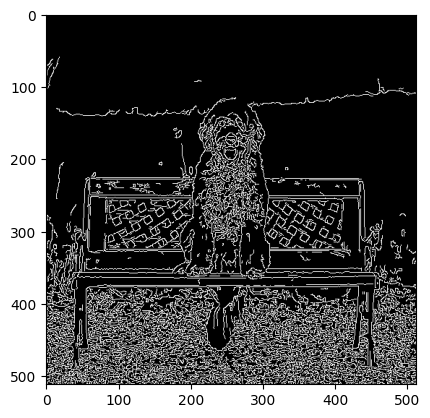

In [ ]:
plt.imshow(canny_image)

In [ ]:
np.unique(np.array(canny_image))

array([  0, 255], dtype=uint8)

# Version 2

0 255 [  0 255]
0 255 [  0 255]


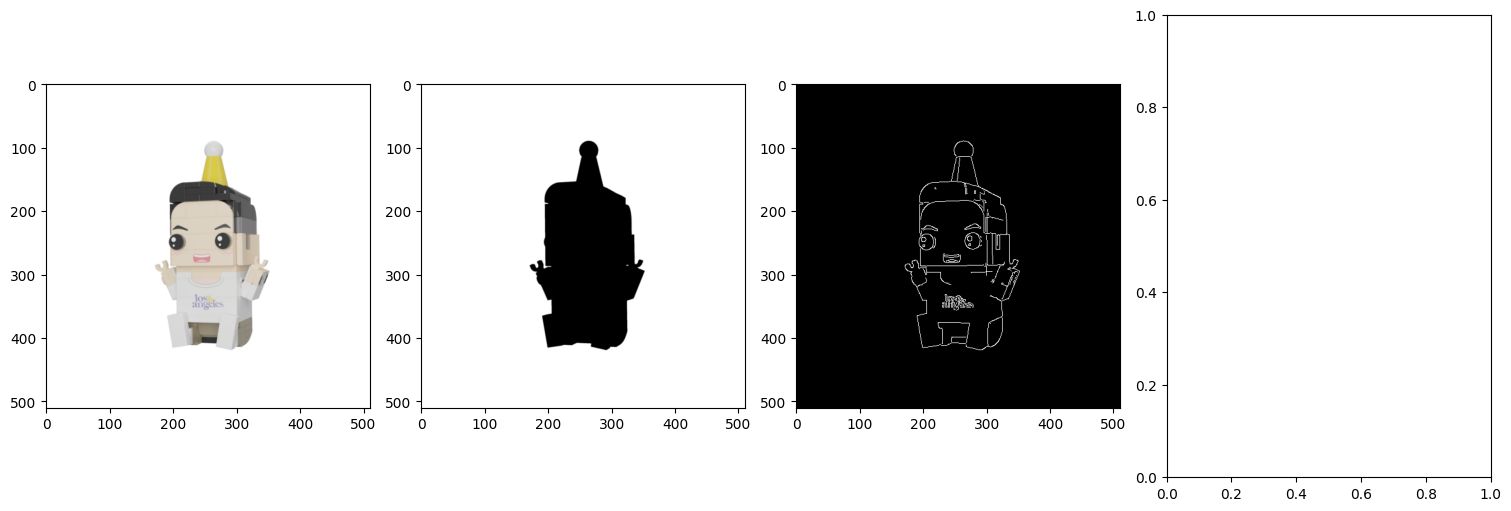

In [ ]:
SIZE = 512
scale = 0.8
image_rgba = Image.open(
        "/home/ubuntu/input_data_toy_boy_v2/0005_RGBA.png"
    )

image_rgb = Image.fromarray(np.array(image_rgba)[:,:,:3])
image_a = np.array(image_rgba)[:,:,3]
print(np.min(image_a),np.max(image_a),np.unique(image_a))
image_mask = 255 - image_a
print(np.min(image_mask),np.max(image_mask),np.unique(image_mask))
image_mask = Image.fromarray(np.repeat(image_mask[:,:,None], 3, axis = 2))
new_size = int(SIZE * scale)

image_transforms_resize = transforms.Compose(
    [
        transforms.Resize(new_size, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Pad(padding = (SIZE - new_size) // 2, fill= (255,255,255), padding_mode='constant'),
    ]
)

mask_transforms_resize = transforms.Compose(
    [
        transforms.Resize(new_size, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Pad(padding = (SIZE - new_size) // 2, fill= (255, 255, 255), padding_mode='constant'),
    ]
)

size_to_pad = (SIZE - new_size) // 2

random_affine = albumentations.augmentations.geometric.transforms.Affine(translate_px = {"x": (-1 * size_to_pad, size_to_pad), "y": (-1 * size_to_pad, size_to_pad)})

image_rgb = image_transforms_resize(image_rgb)
image_mask = mask_transforms_resize(image_mask)

result = random_affine(image = image_rgb, mask = image_mask)

image_rgb = result['image']
image_a = result['mask']

image = image_rgb
mask_image = image_mask

image_np = np.array(image_rgb)

low_threshold = 100
high_threshold = 200

canny_image = cv2.Canny(image_np, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 5),
                        layout="constrained")
#axs[row, column]
axs[0].imshow(image)
axs[1].imshow(mask_image)
axs[2].imshow(canny_image)

# Version 1

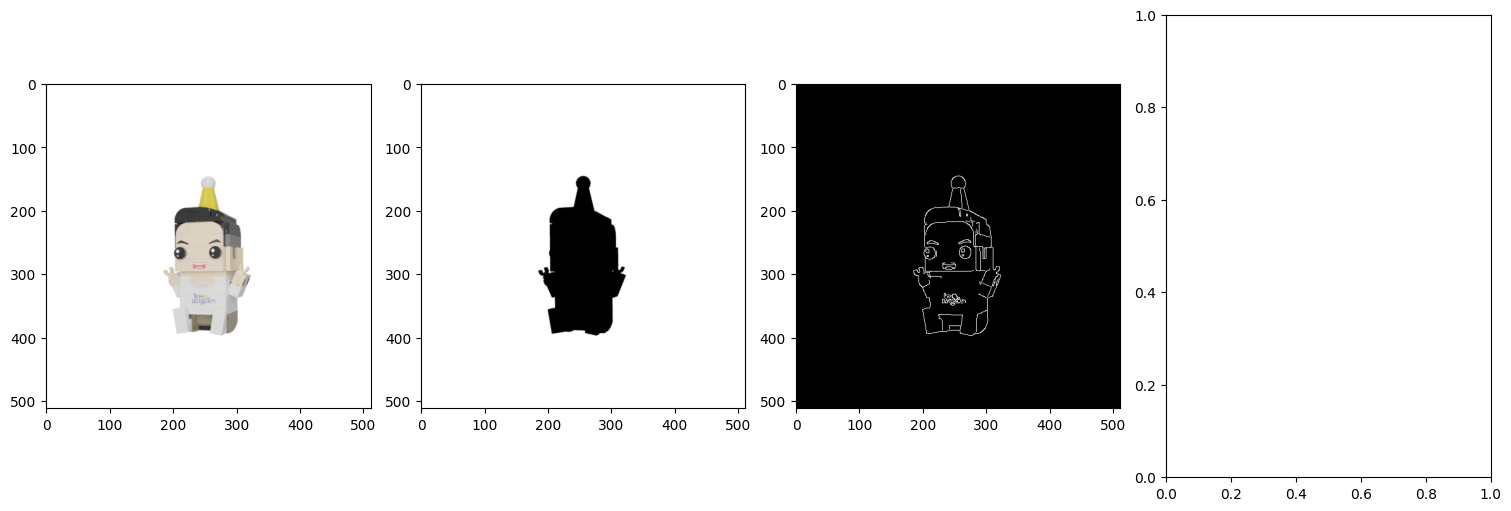

In [ ]:
torch.manual_seed(42)
SIZE = 512
scale = np.random.uniform(low=0.6, high=0.8)
new_size = int(SIZE * scale)
translation = np.random.uniform(low=-1*(SIZE - new_size) // 2, high=(SIZE - new_size) // 2, size=2)

image_rgba = Image.open(
        "/home/ubuntu/input_data_toy_boy_v2/0005_RGBA.png"
    )

image_rgb = Image.fromarray(np.array(image_rgba)[:,:,:3])
image_a = np.array(image_rgba)[:,:,3]
image_mask = 255 - image_a
image_mask = Image.fromarray(np.repeat(image_mask[:,:,None], 3, axis = 2))


image_rgb = transforms.functional.affine(img = image_rgb, angle = 0, scale = scale, shear = 0, translate = translation.tolist(), fill = (255,255,255))
image_mask = transforms.functional.affine(img = image_mask, angle = 0, scale = scale, shear = 0, translate = translation.tolist(), fill = (255,255,255))

# resize
image_rgb = transforms.Resize(SIZE, interpolation=transforms.InterpolationMode.BILINEAR)(image_rgb)
image_mask = transforms.Resize(SIZE, interpolation=transforms.InterpolationMode.BILINEAR)(image_mask)

image = image_rgb
mask_image = image_mask

image_np = np.array(image_rgb)

low_threshold = 100
high_threshold = 200

canny_image = cv2.Canny(image_np, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 5),
                        layout="constrained")
#axs[row, column]
axs[0].imshow(image)
axs[1].imshow(mask_image)
axs[2].imshow(canny_image)

In [ ]:
save_to = Path("/home/ubuntu/0314_inpaint_results")
save_to.mkdir(exist_ok=True)

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 71240.83it/s]
You have disabled the safety checker for <class 'stable_diffusion_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


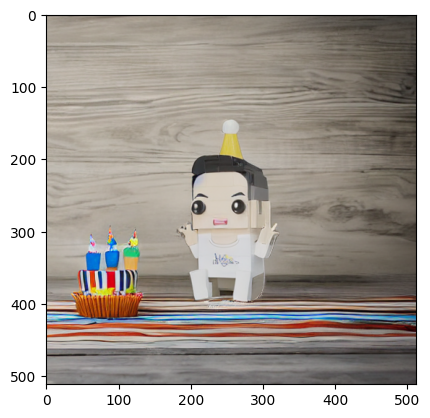

In [ ]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                             #torch_dtype=torch.float16
                                            ).to("cuda")
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
                "runwayml/stable-diffusion-inpainting", controlnet=controlnet, safety_checker=None,
                #torch_dtype=torch.float16
            ).to("cuda")
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

torch.manual_seed(42)
images = []
for i in range(1):
    image_out = pipe(
        "beautiful photo of a toy, sitting on a white table, birthday cake on the table, with colorful balloons on colorful wall, studio quality",
        image,
        mask_image,
        canny_image,
        num_inference_steps=50,
        negative_prompt = "ugly, messy, blurry,low quality"
    ).images[0]
    save_as = save_to / "{:04n}.png".format(i)
    image_out.save(save_as)
    if i < 8:
        images.append(image_out)
    
images = Image.fromarray(np.concatenate(images,axis=1))
save_as = save_to / "{:04n}_concat.png".format(i)
images.save(save_as)
plt.imshow(images)

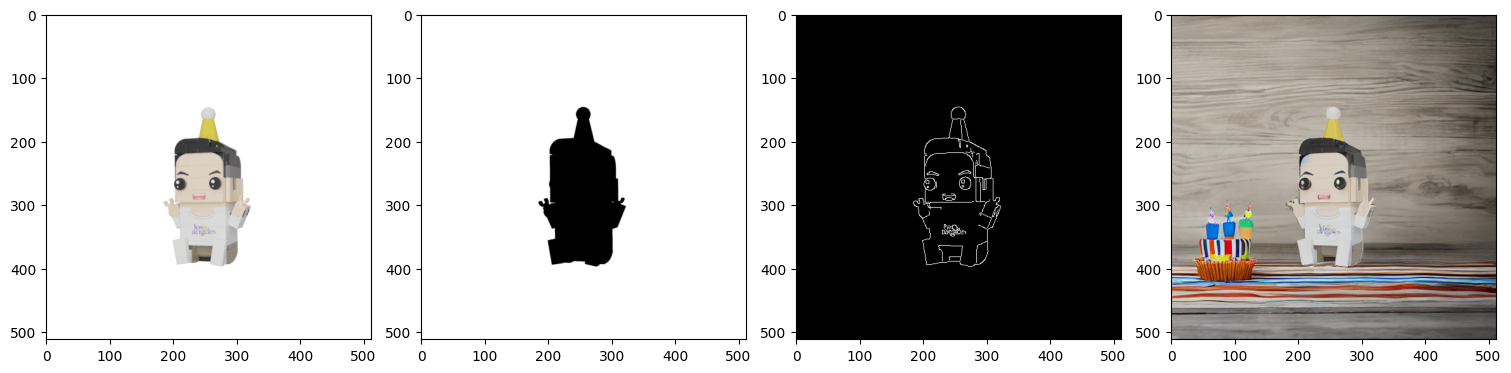

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 5),
                        layout="constrained")
#axs[row, column]
axs[0].imshow(image)
axs[1].imshow(mask_image)
axs[2].imshow(canny_image)
axs[3].imshow(image_out)
fig.sav

# wrap up the function

In [ ]:
def inpaint_with_controlnet_canny(input_name, save_dir, prompt, num_images, n_prompt, num_inference_steps):
    torch.manual_seed(42)
    SIZE = 512
    controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",
                                                 #torch_dtype=torch.float16
                                                ).to("cuda")
    pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
                    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, safety_checker=None,
                    #torch_dtype=torch.float16
                ).to("cuda")
    # pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

    image_rgba = Image.open(input_name)

    image_rgb_original = Image.fromarray(np.array(image_rgba)[:,:,:3])
    image_a = np.array(image_rgba)[:,:,3]
    image_mask = 255 - image_a
    image_mask_original = Image.fromarray(np.repeat(image_mask[:,:,None], 3, axis = 2))
    
    save_to = Path(save_dir)
    save_to.mkdir(exist_ok=True)
    images = []
    
    for i in range(num_images):
        scale = np.random.uniform(low=0.6, high=0.8)
        new_size = int(SIZE * scale)
        translation = np.random.uniform(low=-1*(SIZE - new_size) // 2, high=(SIZE - new_size) // 2, size=2)

        image_rgb = transforms.functional.affine(img = image_rgb_original, angle = 0, scale = scale, shear = 0, translate = translation.tolist(), fill = (255,255,255))
        image_mask = transforms.functional.affine(img = image_mask_original, angle = 0, scale = scale, shear = 0, translate = translation.tolist(), fill = (255,255,255))

        # resize
        image_rgb = transforms.Resize(SIZE, interpolation=transforms.InterpolationMode.BILINEAR)(image_rgb)
        image_mask = transforms.Resize(SIZE, interpolation=transforms.InterpolationMode.BILINEAR)(image_mask)

        image = image_rgb
        mask_image = image_mask

        image_np = np.array(image_rgb)

        low_threshold = 100
        high_threshold = 200

        canny_image = cv2.Canny(image_np, low_threshold, high_threshold)
        canny_image = canny_image[:, :, None]
        canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
        canny_image = Image.fromarray(canny_image)

        image_out = pipe(
            prompt,
            image,
            mask_image,
            canny_image,
            num_inference_steps=50,
            negative_prompt = n_prompt
        ).images[0]
        save_as = save_to / "{:04n}.png".format(i)
        image_out.save(save_as)
        if i < 8:
            images.append(image_out)
            
    images = Image.fromarray(np.concatenate(images,axis=1))
    save_as = save_to / "image_concat.png".format(i)
    images.save(save_as)

    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 5),
                            layout="constrained")
    #axs[row, column]
    axs[0].imshow(image)
    axs[1].imshow(mask_image)
    axs[2].imshow(canny_image)
    axs[2].imshow(image_out)

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 14919.71it/s]
You have disabled the safety checker for <class 'stable_diffusion_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 50/50 [00:07<00:00,  6.83it/s]


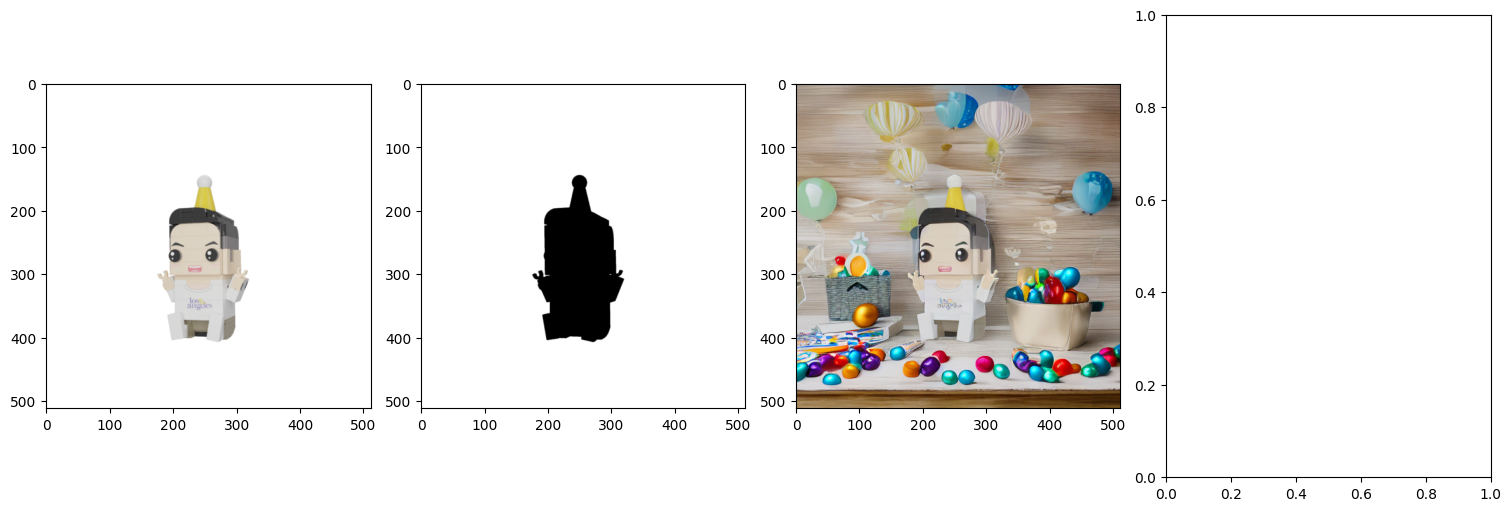

In [ ]:
prompt = "beautiful photo of a toy, sitting on the table with colorful decorations, with colorful balloons in the background, studio quality"
n_prompt = "ugly, messy, blurry,low quality"
inpaint_with_controlnet_canny(input_name="/home/ubuntu/input_data_toy_boy_v2/0005_RGBA.png", save_dir="/home/ubuntu/0314_inpaint_results", prompt=prompt, num_images = 10, n_prompt=n_prompt, num_inference_steps=50)

# Segmentation

In [ ]:
def ade_palette():
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")
image_segmentor = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-small")
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
                "runwayml/stable-diffusion-inpainting", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
            )


In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

In [ ]:
def image_to_seg(image):
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    with torch.no_grad():
        outputs = image_segmentor(pixel_values)
    seg = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)  # height, width, 3
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    color_seg = color_seg.astype(np.uint8)
    seg_image = Image.fromarray(color_seg)
    return seg_image

In [ ]:
image = load_image(
        "https://github.com/CompVis/latent-diffusion/raw/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
    )
mask_image = load_image(
    "https://github.com/CompVis/latent-diffusion/raw/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
)

controlnet_conditioning_image = image_to_seg(image)

image_out = pipe(
    "Face of a yellow cat, high resolution, sitting on a park bench",
    image,
    mask_image,
    controlnet_conditioning_image,
    num_inference_steps=20,
).images[0]

# image.save("out.png")

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(5.5, 3.5),
                        layout="constrained")
#axs[row, column]
axs[0].imshow(image)
axs[1].imshow(mask_image)
axs[2].imshow(controlnet_conditioning_image)
axs[3].imshow(image_out)

In [ ]:
print(np.max(np.array(mask_image)),np.min(np.array(mask_image)))
print(np.unique(np.array(mask_image)))

2 0
[0 1 2]
